In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
dfmap = {}

In [3]:
def get_pd_counts(fn, pid=11, df_rat_e=None, df_rat_p=None,
                  Q2range=(1,6), Wrange=(1.6,3.2), tnum=None):
    d = dfmap[fn] if fn in dfmap else pd.read_csv(fn).dropna()
    d = d[~(d.sect.isnull())&~(d.pdl.isnull())&(d.sect>0)&(d.pdl>0)]
    if fn not in dfmap:
        dfmap[fn] = d
    df = d[(d.Q2>=Q2range[0])&(d.Q2<Q2range[1])&(d.W>=Wrange[0])&(d.W<Wrange[1])]
    if tnum is not None:
        df = df[df.tnum==tnum]
    df_e = None if df_rat_e is None else df[(df.id==11)].merge(df_rat_e, on=['sect','pdl'], how='inner')[['evntid','eff','ko_eff']]
    df_p = None if df_rat_p is None else df[(df.id==2212)].merge(df_rat_p, on=['sect','pdl'], how='inner')[['evntid','eff','ko_eff']]
    df = df[(df.id==pid)&(df.sect>0)]
    if df_e is not None:
        df = df.merge(df_e, on='evntid', how='inner', suffixes=['','_e'])
        df['w8'] = np.power(df.eff,-1)*df.ko_eff
        if df_p is not None:
            df = df.merge(df_p, on='evntid', how='inner', suffixes=['','_p'])
            df['w8'] = df.w8*np.power(df.eff_p,-1)*df.ko_eff_p*df.ko_eff
    else:
        df['w8'] = df.id/df.id # constant 1
    df_pdl_n = df.groupby(['sect','pdl']).w8.sum().reset_index()
    df_pdl_n['e'] = df_pdl_n.w8.apply(np.sqrt)
    df_pdl_n.columns = ['sect', 'pdl', 'n', 'e']
    df_pdl_n.set_index(['sect', 'pdl'], drop=False, inplace=True)
    return df_pdl_n

def get_eff(df_exp, df_sim, ko_pdls=None, top_n=2):
    s_rat = df_exp.n/df_sim.n
    s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
    df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
    df_rat.columns = ['sect', 'pdl', 'rat', 'err']
#     df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(top_n).reset_index().groupby('pdl').rat.mean().reset_index()
#     df_pdl_norms.columns=['pdl', 'norm']
#     df_rat = df_rat.merge(df_pdl_norms, on='pdl')
#     df_rat['eff'] = df_rat.rat/df_rat.norm
#     df_rat['eff_err'] = df_rat.err/df_rat.norm
    def knockout_bad(rec):
        return 0 if int(rec.pdl) in ko_pdls[int(rec.sect)-1] else 1
    df_rat['ko_eff'] = df_rat.dropna().apply(knockout_bad, axis=1)
    df_pdl_norms = df_rat[df_rat.ko_eff>0].reset_index(drop=True).groupby('pdl').rat.nlargest(top_n).reset_index().groupby('pdl').rat.mean().reset_index()
    df_pdl_norms.columns=['pdl', 'norm']
    df_rat = df_rat.merge(df_pdl_norms, on='pdl')
    df_rat['eff'] = df_rat.rat/df_rat.norm
    df_rat['eff_err'] = df_rat.err/df_rat.norm
    return df_rat

def draw_pdl_eff(df_rat, ax=None):
    fig = None
    if ax is None:
        fig = plt.figure()
        ax = fig.axes[0]
    for k, g in df_rat.groupby('sect'):
        X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
        fig = ax.errorbar(X, Y, yerr=Yerr, label=r'S%d'%k, fmt='.')
#     ax.legend(loc=(0.25,0.2), ncol=3, fontsize=10)
    ax.grid()
    ax.set_ylim(-0.05, 1.5)
    return fig

In [8]:
def draw_treffs(df_rat_e, df_rat_p, df_rat_pip):
    fig, axes = plt.subplots(1,3, figsize=(6.5, 2), sharey=True)
    irow, icol = 0, 0
    for df_rat in [df_rat_e, df_rat_p, df_rat_pip]:
        draw_pdl_eff(df_rat, axes[icol])
        icol += 1
    #plt.legend()
    plt.show()
    
def generate_treffs(fn_exp, fn_sim, fn_treffs, ko_pdls=None, top_n=2,
                    Q2ranges={0:(1.25,2.25)}, Wranges=[(1.72,2.8)]):
    fout = open(fn_treffs, 'w')
    print('particle,sect,pdl,eff,eff_err,ko_eff,Q2lo,Q2hi', file=fout)
    for tnum, Q2r in Q2ranges.items():
        tnum = None if tnum==-1 else tnum
        for Wr in Wranges:
            print('###')
            print('Q2 = (%.3f, %.3f]'%Q2r)
            print('W  = (%.3f, %.3f]'%Wr)

            df_rat_e = get_eff(get_pd_counts(fn_exp, 11, Q2range=Q2r, Wrange=Wr),
                               get_pd_counts(fn_sim, 11, Q2range=Q2r, Wrange=Wr, tnum=tnum),
                               ko_pdls=ko_pdls, top_n=top_n)
            
#             df_rat_p = get_eff(get_pd_counts(fn_exp, 2212, df_rat_e, Q2range=Q2r, Wrange=Wr),
            df_rat_p = get_eff(get_pd_counts(fn_exp, 2212, None, Q2range=Q2r, Wrange=Wr),
                               get_pd_counts(fn_sim, 2212, Q2range=Q2r, Wrange=Wr, tnum=tnum),
                               ko_pdls=ko_pdls, top_n=top_n)

#             df_rat_pip = get_eff(get_pd_counts(fn_exp, 211, df_rat_e, df_rat_p, Q2range=Q2r, Wrange=Wr),
            df_rat_pip = get_eff(get_pd_counts(fn_exp, 211, None, None, Q2range=Q2r, Wrange=Wr),
                                 get_pd_counts(fn_sim, 211, Q2range=Q2r, Wrange=Wr, tnum=tnum),
                                 ko_pdls=ko_pdls, top_n=top_n)

            draw_treffs(df_rat_e, df_rat_p, df_rat_pip)
            
            w8_tot = None
            for pid, df_rat in zip([11,2212,211], [df_rat_e, df_rat_p, df_rat_pip]):
                mval = df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)&(df_rat.eff>0)].eff.mean()
                print('%d\t%.4f'%(pid,mval))
                w8_tot = mval if w8_tot is None else w8_tot*mval
            print('--------------\nEVNT\t%.4f'%w8_tot)
            print('###')
            for xtreff,df_rat in zip(['e', 'p', 'pip'],[df_rat_e, df_rat_p, df_rat_pip]):
                for idx,rec in df_rat[['sect','pdl','eff','eff_err','ko_eff']].dropna().iterrows():
                    print('%s,%d,%d,%.4f,%.4f,%d,%.3f,%.3f'%((xtreff,)+tuple(rec)+Q2r), file=fout)
    fout.close()

###
Q2 = (1.250, 5.250]
W  = (1.720, 2.800]


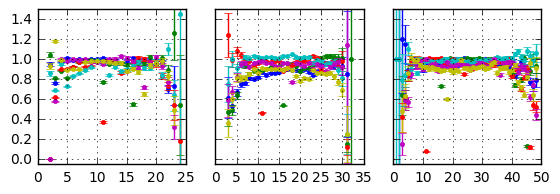

11	0.8972
2212	0.8906
211	0.9204
--------------
EVNT	0.7354
###
###
Q2 = (1.250, 5.250]
W  = (1.720, 2.800]


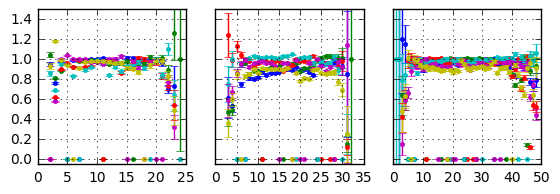

11	0.9319
2212	0.8990
211	0.9270
--------------
EVNT	0.7767
###


In [9]:
fn_exp = '../e1f6/test/pd_counts_exp_e1f.csv'
fn_sim = '../e1f6/test/pd_counts_sim_e1f.csv'
fn_treffs = 'tr_eff_e1f.out'
fn_treffs_koed = 'tr_eff_e1f_koed.out'

Wranges = [(1.72,2.8)]
# Wranges = [(w0, w0+0.2) for w0 in np.arange(1.72,2.8,0.2)]
bad_paddles = [ [], [], [], [], [], [] ]
generate_treffs(fn_exp, fn_sim, fn_treffs, ko_pdls=bad_paddles, Q2ranges={-1:(1.25,5.25)}, Wranges=Wranges)
bad_paddles = [
                [5,7,24],
                [5,11,16,28,38],
                [2,11,24,25,27,28],
                [5,7,19,24,30,34,42,45],
                [2,15,18,20,21,28,34,36],
                [1,6,18,40]
              ]
generate_treffs(fn_exp, fn_sim, fn_treffs_koed, ko_pdls=bad_paddles, Q2ranges={-1:(1.25,5.25)}, Wranges=Wranges)
# generate_treffs(fn_exp, fn_sim, fn_treffs_koed, ko_pdls=bad_paddles, Q2ranges={1:(1.9,2.2)}, Wranges=[(1.72,1.9)])

# df1 = pd.read_csv(fn_sim)
# # df2 = pd.read_csv(fn_exp)
# df1.hist('Q2', 'tnum', bins=100)
# del df1
# del df2
# Q2ranges = { 0:(1.25,2.25),
#              1:(1.75,2.75),
#              2:(2.25,3.25),
#              3:(2.75,3.75),
#              6:(4.25,5.25) }
# Q2ranges = { 0:(1.5,2.0),
#              1:(2.0,2.5),
#              2:(2.5,3.0),
#              3:(3.0,3.5),
#              6:(4.5,5.0) }
# generate_treffs(fn_exp, fn_sim, fn_treffs, ko_pdls=bad_paddles,
#                 Q2ranges=Q2ranges, Wranges=Wranges)

particle,sect,pdl,eff,eff_err,ko_eff,Q2lo,Q2hi <_io.TextIOWrapper name='tr_eff_e16.out' mode='w' encoding='UTF-8'>
###
Q2 = (1.250, 5.250]
W  = (1.720, 2.800]


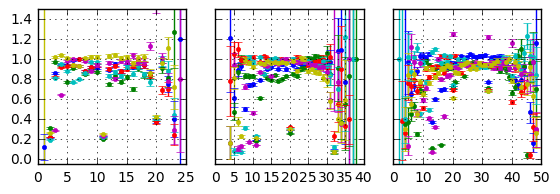

11	0.8460
2212	0.8131
211	0.8498
--------------
EVNT	0.5845
###
particle,sect,pdl,eff,eff_err,ko_eff,Q2lo,Q2hi <_io.TextIOWrapper name='tr_eff_e1f_koed.out' mode='w' encoding='UTF-8'>
###
Q2 = (1.250, 5.250]
W  = (1.720, 2.800]


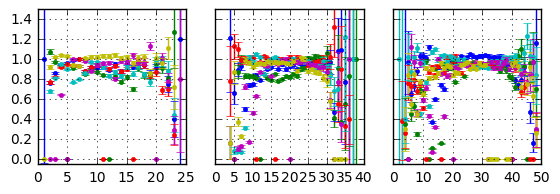

11	0.9027
2212	0.8587
211	0.8710
--------------
EVNT	0.6751
###


In [7]:
fn_exp = '../e1f6/test/pd_counts_exp_e16.csv'
fn_sim = '../e1f6/test/pd_counts_sim_e16.csv'
fn_treffs = 'tr_eff_e16.out'
fn_treff_koed = 'tr_eff_e16_koed.out'

Wranges = [(1.72,2.8)]
# Wranges = [(w0, w0+0.2) for w0 in np.arange(1.72,2.8,0.2)]
# bad_paddles = [
#     [45],
#     [5,45],
#     [11,24,37,38,40,42,45,46,47],
#     [],
#     [5,20,32,40,42],
#     [32,33,34,35,36,37,38,39,44]
# ]
bad_paddles = [ [], [], [], [], [], [] ]
generate_treffs(fn_exp, fn_sim, fn_treffs, ko_pdls=bad_paddles, Q2ranges={-1:(1.25,5.25)}, Wranges=Wranges, top_n=2)
bad_paddles = [
    [45],
    [5,12,45],
    [11,16,24,37,38,40,42,45,46,47],
    [1,34],
    [2,3,5,20,32,40,42],
    [1,32,33,34,35,36,37,38,39,44]
]
generate_treffs(fn_exp, fn_sim, fn_treffs_koed, ko_pdls=bad_paddles, Q2ranges={-1:(1.25,5.25)}, Wranges=Wranges, top_n=2)
# generate_treffs(fn_exp, fn_sim, fn_treffs_koed, ko_pdls=bad_paddles, Q2ranges={1:(1.9,2.2)}, Wranges=[(1.72,1.9)], top_n=2)

# df1 = pd.read_csv(fn_sim)
# df1.hist('Q2', 'tnum', bins=100)
# del df1
# Q2ranges = { 0:(3.0,3.5),
#              1:(4.5,5.0) }

# generate_treffs(fn_exp, fn_sim, fn_treffs,
#                 Q2ranges=Q2ranges, Wranges=Wranges,
#                 ko_pdls=ko_pdls)

particle,sect,pdl,eff,eff_err,ko_eff,Q2lo,Q2hi <_io.TextIOWrapper name='tr_eff_e1f_koed.out' mode='w' encoding='UTF-8'>
###
Q2 = (1.900, 2.200]
W  = (1.720, 1.900]


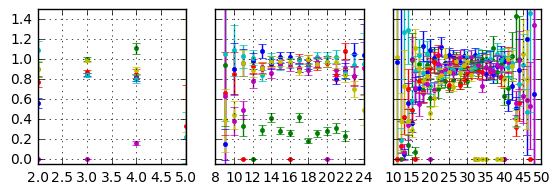

11	0.8260
2212	0.8218
211	0.8448
--------------
EVNT	0.5734
###


In [10]:
generate_treffs(fn_exp, fn_sim, fn_treffs_koed, ko_pdls=bad_paddles, Q2ranges={1:(1.9,2.2)}, Wranges=[(1.72,1.9)], top_n=2)

# Alternative

In [16]:
from rootpy.io import root_open
from rootpy import asrootpy
%matplotlib inline
%run util_draw.py
import rootpy as rpy

def get_vhists(h):
    hacc = rpy.plotting.Hist(25,0,0.5,title='acc')
    #herr = rpy.plotting.Hist(100,0,1,title='err')
    for ibin in range(0,h.GetNcells()):
        val = h.GetBinContent(ibin)
#         err = 0 if val==0 else h.GetBinError(ibin)/val
        hacc.Fill(val)
#         herr.Fill(err)
    hacc.SetBinContent(0,0)
    hacc.SetBinError(0,0)
#     herr.SetBinContent(0,0)
#     herr.SetBinError(0,0)
    hacc.SetBinContent(1,0)
    hacc.SetBinError(1,0)
#     herr.SetBinContent(1,0)
#     herr.SetBinError(1,0)
#     return (hacc,herr)
    return hacc

In [17]:
def get_q2w_hists(fn='../e1f6/test/e1f_skim_small_h6_t0_b.root',
                  dn='mon_eid_efid_nphe_hfid_pcor_badsc_mmp_q2w'):
    with root_open(fn, 'r') as fin:
        hs = [asrootpy(fin['%s/hq2_V_w_%d'%(dn,sect)]) for sect in range(1,7)]
        for h in hs:
            h.SetDirectory(0)
            h.Rebin2D(10,10)
            h.Sumw2()
        return hs

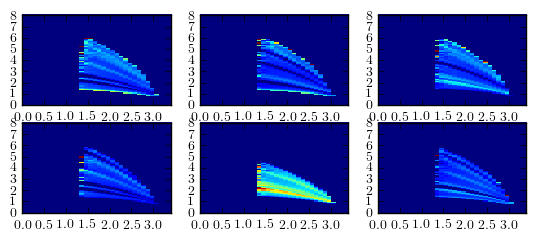

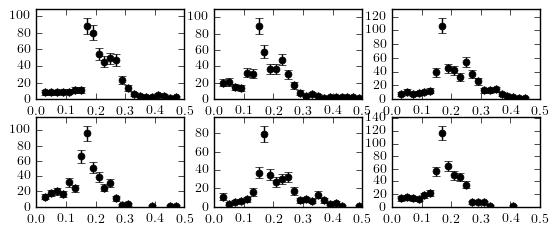

In [20]:
hs_e1f_exp = get_q2w_hists()

hq2w_e1f_exp = hs[0].clone('hq2w_e1f_exp')

for h in hs_e1f_exp[1:]:
    hq2w_e1f_exp.Add(h)

hs_rats_e1f_exp = []
for h in hs_e1f_exp:
    h_rat = asrootpy(h.clone('%s_e1f_exp_rat'%h.GetName()))
    h_rat.Divide(hq2w_e1f_exp)
    hs_rats_e1f_exp.append(h_rat)

mdraw(hs_rats_e1f_exp, 3,2)
plt.show()

hrats_e1f_exp = [get_vhists(hs_rats_e1f_exp[i]) for i in range(0,6)]
mdraw(hrats_e1f_exp, 3, 2)
plt.show()

# Scratch

In [8]:
df_rats = [get_eff(get_pd_counts(fn_exp, pid, Q2range=Q2r),
                   get_pd_counts(fn_sim, pid, Q2range=Q2r, tnum=tnum))
           for pid in [11,2212,211]]

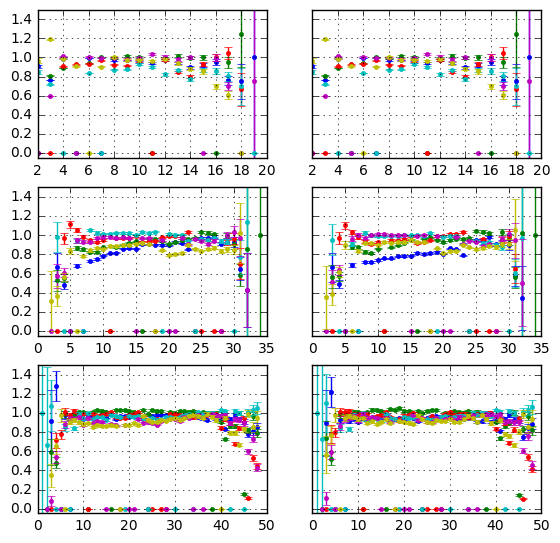

In [9]:
fig, axes = plt.subplots(3,2, figsize=(6.5, 6.5), sharey=True)
irow, icol = 0, 0
for (df_rat1, df_rat2) in zip(df_rats, [df_rat_e, df_rat_p, df_rat_pip]):
    draw_pdl_eff(df_rat1, axes[irow][0])
    draw_pdl_eff(df_rat2, axes[irow][1])
    irow += 1
plt.show()

In [7]:
# w8_tot = None
# print('###')
# print('Q2 = (%.3f, %.3f]'%Q2r)
# for pid, df_rat in zip([11,2212,211], [df_rat_e, df_rat_p, df_rat_pip]):
#     mval = df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)&(df_rat.eff>0)].eff.mean()
#     print('%d\t%.4f'%(pid,mval))
#     w8_tot = mval if w8_tot is None else w8_tot*mval
# print('--------------\nEVNT\t%.4f'%w8_tot)
# print('###')

In [11]:
w8_tot = None
for df_rat in df_rats:
    mval = df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)&(df_rat.eff>0)].eff.mean()
    print(mval)
    w8_tot = mval if w8_tot is None else w8_tot*mval
print(w8_tot)

0.918350525853
0.895370759019
0.920352420194
0.7567728533


# Scratch 2

In [ ]:
fn_exp = '../e1f6/test/pd_counts.csv'
fn_sim = '../e1f6/test/pd_counts_sim.csv'
def get_pd_counts(fn, pid=11):
    df = pd.read_csv(fn)
    df_pdl_n = df[(df.id==pid)&(df.sect>0)].groupby(['sect','pdl']).id.count().reset_index()
    df_pdl_n['e'] = df_pdl_n.id.apply(np.sqrt)
    df_pdl_n.columns = ['sect', 'pdl', 'n', 'e']
    df_pdl_n.set_index(['sect', 'pdl'], drop=False, inplace=True)
    return df_pdl_n

def get_eff(df_exp, df_sim):
    s_rat = df_exp.n/df_sim.n
    s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
    df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
    df_rat.columns = ['sect', 'pdl', 'rat', 'err']
    df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(3).reset_index().groupby('pdl').rat.mean().reset_index()
    df_pdl_norms.columns=['pdl', 'norm']
    df_rat = df_rat.merge(df_pdl_norms, on='pdl')
    df_rat['eff'] = df_rat.rat/df_rat.norm
    df_rat['eff_err'] = df_rat.err/df_rat.norm
    def knockout_bad(rec):
        bad_paddles = [
                        [1,5,7,24],
                        [2,5,11,16,28,38],
                        [3,2,11,24,25,27,28],
                        [4,5,7,19,24,30,34,42,45],
                        [5,2,15,18,20,21,28,34,36],
                        [6,1,6,18,40]
                      ]
        return 0 if int(rec.pdl) in bad_paddles[int(rec.sect)-1] else 1
    df_rat['ko_eff'] = df_rat.apply(knockout_bad, axis=1)
    return df_rat

def draw_pdl_eff(df_rat):
    fig = plt.figure()
    for k, g in df_rat.groupby('sect'):
        X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
        plt.errorbar(X, Y, yerr=Yerr, label=r'S%d'%k, fmt='.', figure=fig)
    plt.legend(loc=(0.25,0.2), ncol=3, fontsize=10)
    plt.grid()
    plt.ylim(-0.05, 1.5)
    return fig

In [28]:
df_exp = df_exp[df_exp.pdl<22]
df_sim = df_sim[df_sim.pdl<22]
s_rat = df_exp.n/df_sim.n
s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
df_rat.columns = ['sect', 'pdl', 'rat', 'err']

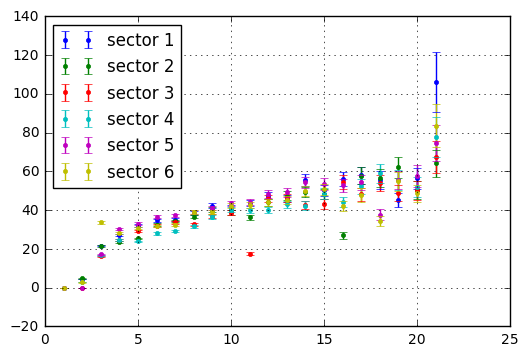

In [33]:
for k, g in df_rat[df_rat.pdl<25].groupby('sect'):
    X, Y, Yerr = g.pdl.values, g.rat.values, g.err.values
    plt.errorbar(X, Y, yerr=Yerr, label=r'sector %d'%k, fmt='.')
plt.legend(loc='best')
plt.grid()

In [60]:
df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(2).reset_index().groupby('pdl').rat.mean().reset_index()
df_pdl_norms.columns=['pdl', 'norm']

In [62]:
df_rat = df_rat.merge(df_pdl_norms, on='pdl')
df_rat['eff'] = df_rat.rat/df_rat.norm

In [64]:
df_rat['eff_err'] = df_rat.err/df_rat.norm

In [73]:
def knockout_bad(rec):
    bad_paddles = [
                    [1,5,7,24],
                    [2,5,11,16,28,38],
                    [3,2,11,24,25,27,28],
                    [4,5,7,19,24,30,34,42,45],
                    [5,2,15,18,20,21,28,34,36],
                    [6,1,6,18,40]
                  ]
    return 0 if int(rec.pdl) in bad_paddles[int(rec.sect)-1] else 1

In [76]:
df_rat['ko_eff'] = df_rat.apply(knockout_bad, axis=1)

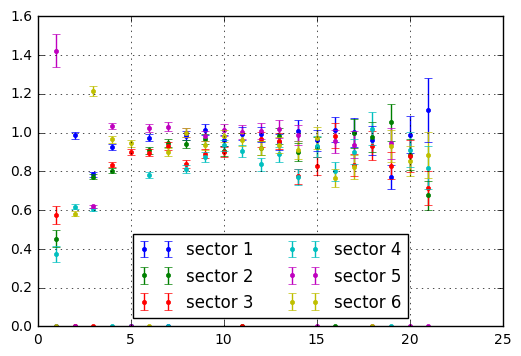

In [84]:
for k, g in df_rat.groupby('sect'):
    X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
    plt.errorbar(X, Y, yerr=Yerr, label=r'sector %d'%k, fmt='.')
plt.legend(loc='lower center', ncol=2)
plt.grid()

In [85]:
df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)].eff.mean()

0.90432721872471067

In [29]:
df_rat['sect'] = df_rat.sect.astype(int)
df_rat['pdl'] = df_rat.pdl.astype(int)

In [31]:
df_rat.columns

Index(['sect', 'pdl', 'rat', 'err', 'norm', 'eff', 'eff_err', 'ko_eff'], dtype='object')

# By CC PMT

In [ ]:
dn = '../e1f6/test'
fn_tmpl = '%s_skim_small.root'
def get_sectVpmt(exp='e1f', tpath='h10_eid_efid_nphe_hfid_mmp/h10', fn=None):
    if fn is None:
        fn = fn_tmpl%exp
    with root_open('%s/%s'%(dn,fn), 'r') as fin:
        h10 = asrootpy(fin[tpath])
        h10.SetAlias("segm","int((cc_segm[cc[0]-1]%1000)/10)")
        h10.SetAlias("sect","cc_sect[cc[0]-1]")
        h10.SetAlias("pmt","(2*segm-1)+(cc_segm[cc[0]-1]/1000-1>0)*1")
        hcc2d = h10.Draw("pmt:sect>>h2(36,0.5,36.5,6,0.5,6.5)", "", "goff")
        hcc2d.SetDirectory(0)
        hcc2d.SetName('hcc2d_%s'%exp)
        return asrootpy(hcc2d)
    
def get_pmtPerSect(h_sectVpmt):
    hs = []
    h2 = h_sectVpmt.Clone('h2')
    h2.reset()
    for pmt in range(1,39):
        h = asrootpy(h_sectVpmt.ProjectionY('hpmt', pmt, pmt))
        nval = np.mean(np.sort(list(h.y()))[-2:])
        for sect in range(1,7):
            val = h_sectVpmt.GetBinContent(pmt,sect)
            err = h_sectVpmt.GetBinError(pmt,sect)
            h2.SetBinContent(pmt,sect, val/nval)
            h2.SetBinError(pmt,sect, err/nval)
    for sect in range(1,7):
        hname = '%s_S%d'%(h_sectVpmt.GetName(),sect)
        h = h2.ProjectionX(hname, sect, sect)
        h.SetDirectory(0)
        hs.append(asrootpy(h))
    return hs

In [ ]:
h2_e1f = get_sectVpmt()
h2_e16 = get_sectVpmt('e16')

h2_e1f_sim = get_sectVpmt(exp='e1f_sim', tpath='h10_eid_efid_nphe_mmp/h10',
                          fn='e1f_sample60_skim_small.root')
h2_e16_sim = get_sectVpmt(exp='e16_sim', tpath='h10_eid_efid_nphe_mmp/h10',
                          fn='e16_sample60_skim_small.root')

In [ ]:
hs_e1f_sim = get_pmtPerSect(h2_e1f_sim)
hs_e16_sim = get_pmtPerSect(h2_e16_sim)

hs_e1f = get_pmtPerSect(h2_e1f)
hs_e16 = get_pmtPerSect(h2_e16)

In [ ]:
for (h,hsim) in zip(hs_e1f, hs_e1f_sim):
    h.Divide(hsim)
for (h,hsim) in zip(hs_e16, hs_e16_sim):
    h.Divide(hsim)

In [ ]:
fig = plt.figure()
colors = ['b', 'g', 'r', 'c', 'y', 'm', 'k']
for icolor,h in enumerate(hs_e1f):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
    plt.errorbar(X,Y,E, fmt='%s.'%colors[icolor], label=h.get_title())
plt.grid()
plt.ylim(0.9,1.1)
plt.show()

fig = plt.figure()
colors = ['b', 'g', 'r', 'c', 'y', 'm', 'k']
for icolor,h in enumerate(hs_e16):
    X, Y, E = list(h.x()), list(h.y()), list(zip(*h.yerr()))[0]
    plt.errorbar(X,Y,E, fmt='%s.'%colors[icolor], label=h.get_title())
plt.grid()
plt.ylim(0.9,1.1)
plt.show()

In [ ]:
stds = [[], []]
avg_errs = [[], []]
for pmt in range(1,37):
    stds[0].append(np.std([h.GetBinContent(pmt) for h in hs_e16]))
    stds[1].append(np.std([h.GetBinContent(pmt) for h in hs_e1f]))
    avg_errs[0].append(np.mean([h.GetBinError(pmt) for h in hs_e16]))
    avg_errs[1].append(np.mean([h.GetBinError(pmt) for h in hs_e1f]))
X = range(1,37)
std_e16, std_e1f = stds
err_e16, err_e1f = avg_errs

In [ ]:
fig = plt.figure()
plt.plot(X,std_e1f, 'ro-', label='e1f')
plt.plot(X,std_e16, 'bo-', label='e16')
plt.grid()
plt.legend()
plt.show()
fig = plt.figure()
plt.plot(X,std_e1f, 'ro-', label='e1f, std')
plt.plot(X,err_e1f, 'bo-', label='e1f, err')
plt.grid()
plt.legend()
plt.show()
fig = plt.figure()
plt.plot(X,std_e16, 'ro-', label='e16, std')
plt.plot(X,err_e16, 'bo-', label='e16, err')
plt.legend()
plt.grid()
plt.show()